In [54]:
!pip install seaborn==0.12.0


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
dataTrain = pd.read_csv("OccupancyTrain.csv")
dataTest = pd.read_csv("OccupancyTest.csv")

dataTrain.columns = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]
dataTest.columns = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]

dataTrain.head()

Temperature  Humidity   Light          CO2  HumidityRatio  Occupancy
0        22.10      26.6  464.00  1073.250000       0.004375        1.0
1        19.39      27.2    0.00   463.000000       0.003783        0.0
2        20.60      19.5    0.00   435.000000       0.002919        0.0
3        21.50      33.5  475.25  1281.500000       0.005320        1.0
4        19.29      31.6    0.00   437.333333       0.004371        0.0

In [57]:
plt.figure(figsize=(8, 5))

plt.bar(np.array([0, 1]), df_train["Occupancy"].value_counts(), width=0.4, color=["blue", "red"])

plt.xticks([0, 1], labels=["Unoccupied", "Occupied"])
plt.xlim(-0.5, 1.5)
plt.xlabel("Occupancy Status")
plt.ylabel("Density")
plt.title("Density Distribution of Occupancy Status")

plt.show()

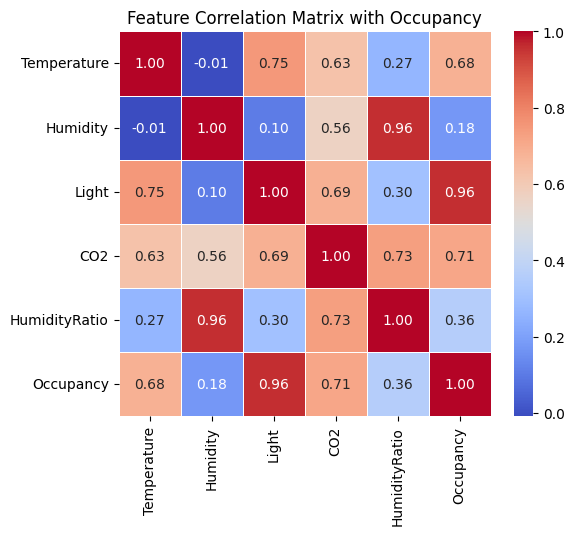

In [71]:
plt.figure(figsize=(6, 5))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Matrix with Occupancy")

plt.savefig("correlation_matrix.png", dpi=300, bbox_inches="tight")

plt.show()

In [72]:
from scipy.stats import t

conditions = ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]
occupied = df_train[df_train["Occupancy"]== 1]
unoccupied = df_train[df_train["Occupancy"] == 0]

alpha=0.05
results = []

for con in conditions:
    x = occupied[con].dropna().values
    y = unoccupied[con].dropna().values
    
    #Calculate the sample mean
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    #Calculate the sample standard deviation
    s_x = np.std(x, ddof=1)
    s_y = np.std(y, ddof=1)
    n, m = len(x), len(y)

    #Calculate t-statistics
    t_stat = (x_bar - y_bar) / np.sqrt((s_x**2 / n) + (s_y**2 / m))

    #Calculated degrees of freedom (df)
    df_num = (s_x**2 / n + s_y**2 / m) ** 2
    df_denom = (s_x**4 / (n**2 * (n - 1))) + (s_y**4 / (m**2 * (m - 1)))
    df_effective = df_num / df_denom  

    #Calculate p-value (two-sided test)
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=df_effective))

    reject_H0 = int(p_value < alpha)

    results.append([con, round(x_bar, 2), round(y_bar, 2), round(s_x, 2), round(s_y, 2), 
                    round(t_stat, 2), round(df_effective, 2), round(p_value, 3), reject_H0])
    
result_df = pd.DataFrame(results, columns=["Condition", "Mean (Occupied)", "Mean (Unoccupied)", 
                                           "Std (Occupied)", "Std (Unoccupied)", 
                                           "t-statistic", "Degrees of Freedom (ν)", "p-value", "Reject H0"])
print(result_df)

       Condition  Mean (Occupied)  Mean (Unoccupied)  Std (Occupied)  \
0    Temperature            21.73              20.31            0.62   
1       Humidity            26.96              24.91            6.04   
2          Light           459.59              26.75           41.55   
3            CO2          1041.43             477.53          374.22   
4  HumidityRatio             0.00               0.00            0.00   

   Std (Unoccupied)  t-statistic  Degrees of Freedom (ν)  p-value  Reject H0  
0              0.87        22.93                  535.61      0.0          1  
1              5.48         4.36                  591.90      0.0          1  
2             82.62        80.96                  439.34      0.0          1  
3            115.04        24.94                  355.19      0.0          1  
4              0.00         9.41                  560.53      0.0          1  


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [60]:
XTrain = dataTrain.iloc[:, :-1]. values
YTrain = dataTrain.iloc[:, -1]. values

XTest = dataTest.iloc[:, :-1]. values
YTest = dataTest.iloc[:, -1]. values

In [73]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(XTrain, YTrain)

accTrain = accuracy_score(YTrain, knn.predict(XTrain)) * 100
accTest = accuracy_score(YTest, knn.predict(XTest))* 100

print(f"Training set accuracy: {accTrain:.2f}%")
print(f"Test set accuracy: {accTest:.2f}%")

Training set accuracy: 100.00%
Test set accuracy: 97.74%


In [75]:
cv = KFold(n_splits=5)
cv_accuracies = []

for train, test in cv.split(XTrain):
    XTrainCV, XTestCV = XTrain[train], XTrain[test]
    YTrainCV, YTestCV = YTrain[train], YTrain[test]

    knn_cv = KNeighborsClassifier(n_neighbors=1)
    knn_cv.fit(XTrainCV, YTrainCV)
    
    accuracy = accuracy_score(YTestCV, knn_cv.predict(XTestCV))
    cv_accuracies.append(accuracy)

cv_mean_accuracy = np.mean(cv_accuracies)* 100
print(f"Average accuracy of cross-validation: {cv_mean_accuracy:.2f}%")

Average accuracy of cross-validation: 98.16%


In [100]:
k_values = [1, 3, 5, 7, 9, 11]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for k in k_values:
    accuracies = []

    for train, test in cv.split(XTrain):
        XTrainCV, XTestCV = XTrain[train], XTrain[test]
        YTrainCV, YTestCV = YTrain[train], YTrain[test]

        knn_cv = KNeighborsClassifier(n_neighbors=k)
        knn_cv.fit(XTrainCV, YTrainCV)

        accuracy = accuracy_score(YTestCV, knn_cv.predict(XTestCV))
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    cv_accuracies.append(mean_accuracy)
    
best_accuracy = max(cv_accuracies)
k_best_list = [k_values[i] for i, acc in enumerate(cv_accuracies) if acc == best_accuracy]

print(f"Best k values (kbest): {k_best_list}")
print(f"Highest Cross-Validation Accuracy: {best_accuracy*100:.2f}%")

plt.figure(figsize=(6,5))
plt.plot(k_values, cv_accuracies, marker='o', linestyle='-',label="Cross-Validation Accuracy")

for i, k in enumerate(k_values):
    plt.annotate(f"{cv_accuracies[i]*100:.2f}%",  
                 (k, cv_accuracies[i]),  
                 textcoords="offset points", xytext=(0, 8), ha='center', fontsize=10) 

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("k-NN Accuracy vs. Number of Neighbors (5-Fold CV)")
plt.xticks(k_values)
plt.grid(True)
plt.show()


Best k values (kbest): [3, 5, 7, 9]
Highest Cross-Validation Accuracy: 99.16%


In [98]:
k_best = k_best_list[0]

knn_best = KNeighborsClassifier(n_neighbors=k_best)
knn_best.fit(XTrain, YTrain)

train_accuracy = accuracy_score(YTrain, knn_best.predict(XTrain))
test_accuracy = accuracy_score(YTest, knn_best.predict(XTest))

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Training Accuracy: 99.33%
Test Accuracy: 98.75%


Best k values (k_best): [9, 11]
Highest Cross-Validation Accuracy: 99.17%
Train Accuracy: 99.17%
Test Accuracy: 97.74%


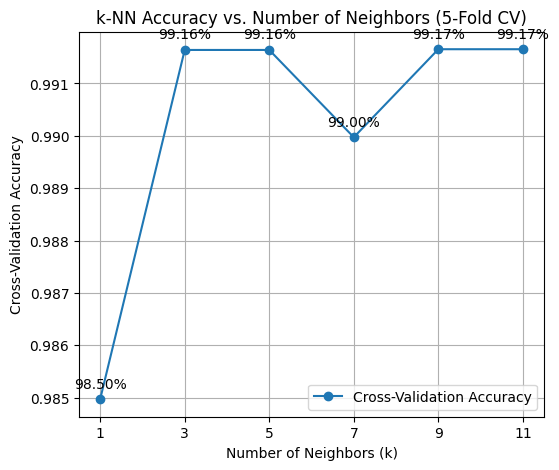

In [99]:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

k_values = [1, 3, 5, 7, 9, 11]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for k in k_values:
    accuracies = []

    for train, test in cv.split(XTrain):
        scaler = preprocessing.StandardScaler().fit(XTrain[train])  
        
        XTrainCV = scaler.transform(XTrain[train])
        XTestCV = scaler.transform(XTrain[test])
        YTrainCV, YTestCV = YTrain[train], YTrain[test]

        knn_cv = KNeighborsClassifier(n_neighbors=k)
        knn_cv.fit(XTrainCV, YTrainCV)

        accuracy = accuracy_score(YTestCV, knn_cv.predict(XTestCV))
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    cv_accuracies.append(mean_accuracy)

best_accuracy = max(cv_accuracies)
k_best_list = [k_values[i] for i, acc in enumerate(cv_accuracies) if acc == best_accuracy]
k_best = k_best_list[0]  

scaler_final = preprocessing.StandardScaler().fit(XTrain)  
XTrainN = scaler_final.transform(XTrain)  
XTestN = scaler_final.transform(XTest)  

knn_best = KNeighborsClassifier(n_neighbors=k_best)
knn_best.fit(XTrainN, YTrain)

train_accuracy = accuracy_score(YTrain, knn_best.predict(XTrainN))
test_accuracy = accuracy_score(YTest, knn_best.predict(XTestN))

print(f"Best k values (k_best): {k_best_list}")
print(f"Highest Cross-Validation Accuracy: {best_accuracy * 100:.2f}%")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


plt.figure(figsize=(6, 5))
plt.plot(k_values, cv_accuracies, marker='o', linestyle='-', label="Cross-Validation Accuracy")

for i, k in enumerate(k_values):
    plt.annotate(f"{cv_accuracies[i] * 100:.2f}%",  
                 (k, cv_accuracies[i]),  
                 textcoords="offset points", xytext=(0, 8), ha='center', fontsize=10)

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("k-NN Accuracy vs. Number of Neighbors (5-Fold CV)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()